# Sentiment Analysis using pre-trained BERT models from Hugging Face

#### I have found this method particularly useful when labeled data in not available, which happens to be the case in most of the scenarios. Based on my experience, it has produced excellent results (precision, recall, F1 and accuracy > 95%). Of course, these numbers are from experiments in which labeled data did exist.

##### The only down side to this approach is that it is not straight forward to quantify the model performance without labeled data. I have used a workaround in several projects and that is to find a proxy for the sentiment ground truth. In many cases, it was the derivative of the c-sat score.  This proxy can be used in place of the labeled data for the purposes of evaluation.

## Install

In [ ]:
!pip3 install torch

In [ ]:
!pip install transformers pandas numpy

## Import the required libraries

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Initialize the pre-trained BERT tokenizer and model for sentiment analysis

In [4]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

## Data Import and Cleanup

In [ ]:
fname = os.path.join("<<your path and input excel file name with extension>>")
df = pd.read_excel (fname)
df.fillna('', inplace=True)
df.head()

In [7]:
df['label'].value_counts()

            843
Positive    156
Negative     75
Other         4
Name: label, dtype: int64

In [8]:
df = df.drop(df[df.Comments == ''].index)

In [9]:
df = df.drop(df[df.label == ''].index)
# df = df.drop(df[df.label == 'Other'].index)

In [10]:
df['label'].value_counts()

Positive    156
Negative     75
Name: label, dtype: int64

In [ ]:
print(df.isnull().sum())
print(df.isna().sum())

## Get the sentiment score for each row

In [12]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [13]:
df['Predicted Sentiment Score'] = df['Comments'].apply(lambda x: sentiment_score(x[:512]))

## Convert the predicted sentiment score to sentiment class and then to its integer representation (1 or 0). While the sentiment class is useful for visually inspecting the results, the integer representation is required for evaluation of the model performance.

In [14]:
def get_sentiment_class(x):
    if x <=2:
        return "Negative"
    elif x == 3:
        return "Negative"
    elif x >= 4:
        return "Positive"

In [15]:
df['Predicted Sentiment'] = df['Predicted Sentiment Score'].apply(get_sentiment_class)

In [16]:
def get_sentiment_category(x):
    if x <=3:
        return 0
    elif x >= 4:
        return 1

In [17]:
df['Predicted Sentiment Category'] = df['Predicted Sentiment Score'].apply(get_sentiment_category)

In [18]:
class_to_index = {"Positive": 1, "Negative": 0, "Other":1}

## Convert the label into an integer to help with evaluation of the model performance.

In [19]:
df["label_int"] = df["label"].apply(lambda x: class_to_index[x])

In [21]:
confusion_matrix(df['label_int'], df['Predicted Sentiment Category'], labels=[1, 0])

array([[147,   9],
       [  3,  72]], dtype=int64)

In [22]:
confusion_matrix(df['label_int'], df['Predicted Sentiment Category'], normalize='true', labels=[1, 0])

array([[0.94230769, 0.05769231],
       [0.04      , 0.96      ]])

In [23]:
print("Precision: " + str(precision_score(df['label_int'], df['Predicted Sentiment Category'], labels=[1, 0])))
print("Recall: " + str(recall_score(df['label_int'], df['Predicted Sentiment Category'], labels=[1, 0])))
print("F1 Score: " + str(f1_score(df['label_int'], df['Predicted Sentiment Category'], labels=[1, 0])))
print("Accuracy: " + str(accuracy_score(df['label_int'], df['Predicted Sentiment Category'])))

Precision: 0.98
Recall: 0.9423076923076923
F1 Score: 0.9607843137254902
Accuracy: 0.948051948051948


In [24]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 2)), labels=classes)
    plt.yticks(list(range(0, 2)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

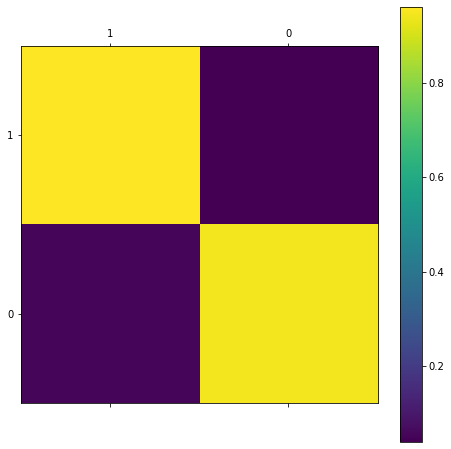

In [25]:
show_confusion_matrix(df['label_int'], df['Predicted Sentiment Category'], [1, 0])

## Retaining the columns from the data frame for the final output

In [ ]:
df = df[['Id', 'Comments', 'Predicted Sentiment Score', 'Predicted Sentiment', 'label']]

In [37]:
df.to_excel("<<your path and output excel file name with extension>>", sheet_name='Sentiment Analysis')